In [1]:
import tensorflow as tf
import sys
sys.path.append('../')
import read_stl10_file
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

sess=tf.Session()    
saver = tf.train.import_meta_graph('./model/final_model.meta')
saver.restore(sess,tf.train.latest_checkpoint('./model'))
graph = tf.get_default_graph()


# for op in graph.get_operations():
#     print(op.name)
# Annotated due to print to many rows

xs = graph.get_tensor_by_name("conv3/Conv2D:0")
ys = graph.get_tensor_by_name("logits/BiasAdd:0")

grads = [tf.gradients(ys[0, i], xs) for i in range(10)]

X = graph.get_tensor_by_name("X:0")
Y = graph.get_tensor_by_name("Y:0")

pred = graph.get_tensor_by_name("ArgMax:0")
correct = graph.get_tensor_by_name("Equal:0")

images_test = read_stl10_file.read_all_images(read_stl10_file.DATA_PATH)[0:50]
labels_test = read_stl10_file.read_labels(read_stl10_file.LABEL_PATH)[0:50] - 1
oh_ = tf.one_hot(labels_test, depth=10)
gr_ = tf.image.rgb_to_grayscale(images_test)
images_test_gray, labels_test_onehot = sess.run([gr_, oh_])

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


sys.version_info(major=3, minor=6, micro=4, releaselevel='final', serial=0)
INFO:tensorflow:Restoring parameters from ./model\final_model


In [75]:
index = 36

This is monkey
Prediction: cat
Correct: False


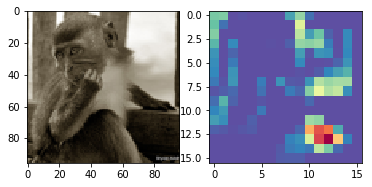

In [76]:
image_sample = images_test[index,:,:,:]
image_sample_gray = images_test_gray[index,:,:,:]
label_sample = labels_test_onehot[index]
image_sample_feed = images_test_gray[index:index+1,:,:,:]
label_sample_feed = labels_test_onehot[index:index+1]

img = image_sample.astype('int')


label_name = ['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck']
index_of_real = label_sample.argmax()
print('This is', label_name[index_of_real])

training = graph.get_tensor_by_name("Placeholder:0")

f, p, corr, logits= sess.run([xs, pred, correct, ys], feed_dict={X:image_sample_feed, Y:label_sample_feed, training:False})
index_of_prediction = p[0]
print('Prediction:',label_name[index_of_prediction])
print('Correct:', corr[0])
G_real, G_pred = sess.run([grads[index_of_real], grads[index_of_prediction]], feed_dict={X:image_sample_feed, training:False})
G = G_pred[0]

alpha = G.mean(axis=(0,1,2))
L = f * alpha
d = L.max() - L.min()

L_grad_cam = L.sum(axis=(0,3))

L_grad_cam = np.maximum(L_grad_cam, 0)
L_grad_cam = L_grad_cam / d * 255
L_grad_cam = L_grad_cam.astype('int')

fig = plt.figure()
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

ax1.imshow(img.astype('uint8'))
# cmap을 반대로 해주기 위해 255에서 빼주기
ax2.imshow(255-L_grad_cam, cmap="Spectral")

plt.imsave('real-{}.png'.format(index),img.astype('uint8'))
plt.imsave('gradcam_pred-{}.png'.format(index),255-L_grad_cam, cmap="Spectral")
plt.show()

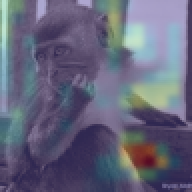

In [70]:
img_real = Image.open('real-{}.png'.format(index))
img_grad_pred = Image.open('gradcam_pred-{}.png'.format(index))
img_real, img_grad_pred = [x.resize((192,192)) for x in (img_real, img_grad_pred)]


from PIL import ImageFilter
# conv layer의 resoultion이 낮아서 blur처리
img_grad_pred = img_grad_pred.filter(ImageFilter.GaussianBlur(radius=3))

# https://stackoverflow.com/questions/10640114/overlay-two-same-sized-images-in-python
img_real = img_real.convert("RGBA")
img_grad_pred = img_grad_pred.convert("RGBA")

new_img = Image.blend(img_real, img_grad_pred, 0.5)
new_img.save('result-{}.png'.format(index))
new_img